In [1]:
# Original program:
# https://github.com/JohnBracken/2D-wave-equation/blob/master/2DWaveEquation.py

In [2]:
# Import libraries needed
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from numba import njit, prange

In [3]:
# Set position
def set_pos():
    axis_size = 100  # grid size
    length = 1  # length of plot axes
    dx, dy = length/axis_size, length/axis_size  # rates of change
    points = np.linspace(0, length, axis_size)  # grid points
    c = 1/np.sqrt(2)  # constant
    return axis_size, dx, dy, points, c

axis_size, dx, dy, points, c = set_pos()

In [4]:
# Set time grid
def set_time():
    T = 20  # total time in seconds
    dt = 0.5*(1/c)*(1/np.sqrt(dx**(-2)+dy**(-2)))  # rate of change with respect to time
    n = int(T/dt)  # number of time steps
    return dt, n

dt, n = set_time()

In [5]:
# Initialization condition for a 2D sine wave
def initial_cond(x,y):
    return np.sin(2*np.pi*x + 2*np.pi*y)

In [6]:
# Create meshgrid
X, Y = np.meshgrid(points, points)

In [7]:
# Solve the partial differential equation numerically with iteration
def numerical_sol():
    # initial condition
    U = initial_cond(X, Y)

    # initial boundary conditions
    B1 = U[:, 0]
    B2 = U[:, -1]
    B3 = U[0, :]
    B4 = U[-1, :]

    U1 = np.zeros((axis_size, axis_size))

    # second initial condition
    U1[1:-1, 1:-1] = (U[1:-1, 1:-1] + (c**2/2)*(dt**2/dx**2)*(U[1:-1, 0:-2] - 2*U[1:-1, 1:-1] + U[1:-1, 2:]) +
         (c**2/2)*(dt**2/dy**2)*(U[0:-2, 1:-1] - 2*U[1:-1, 1:-1] + U[2:, 1:-1]))

    U1[:, 0] = B1
    U1[:, -1] = B2
    U1[0, :] = B3
    U1[-1, :] = B4

    # second initial boundary conditions
    B5 = U1[:, 0]
    B6 = U1[:, -1]
    B7 = U1[0, :]
    B8 = U1[-1, :]

    U2 = np.zeros((axis_size, axis_size))

    map_array = np.zeros((axis_size, axis_size, n))

    # initial wave maps
    map_array[:, :, 0] = U
    map_array[:, :, 1] = U1
    for i in range(2, n):

        U2[1:-1, 1:-1] = (2*U1[1:-1, 1:-1] - U[1:-1, 1:-1] + (c**2)*((dt/dx)**2)*(U1[1:-1, 0:-2] - 2*U1[1:-1, 1:-1] +
                        U1[1:-1, 2:]) + (c**2)*((dt/dy)**2)*(U1[0:-2, 1:-1] - 2*U1[1:-1, 1:-1] +
                        U1[2:, 1:-1]))

        # dirichlet boundary conditions
        U2[:, 0] = B5
        U2[:, -1] = B6
        U2[0, :] = B7
        U2[-1, :] = B8

        U1[:, 0] = B5
        U1[:, -1] = B6
        U1[0, :] = B7
        U1[-1, :] = B8

        U[:, 0] = B1
        U[:, -1] = B2
        U[0, :] = B3
        U[-1, :] = B4

        # update wave map with two-dimensional data
        map_array[:, :, i] = U2
        
        # update to leading wave maps for next iteration
        U = U1
        U1 = U2
    return map_array

user_time, sys_time, _, _, _ = os.times()

print("User time: {:.3f} seconds".format(user_time))
print("System time: {:.3f} seconds".format(sys_time))

User time: 0.790 seconds
System time: 0.100 seconds


In [8]:
start = time.time()
set_pos()
end = time.time()
print("Seconds elapsed = %s" % (end - start))

Seconds elapsed = 0.00024366378784179688


In [9]:
start = time.time()
set_time()
end = time.time()
print("Seconds elapsed = %s" % (end - start))

Seconds elapsed = 7.128715515136719e-05


In [10]:
start = time.time()
initial_cond(X, Y)
end = time.time()
print("Seconds elapsed = %s" % (end - start))

Seconds elapsed = 0.0007648468017578125


In [11]:
start_1 = time.time()
numerical_sol()
end_1 = time.time()
time_1 = end_1 - start_1
print("Seconds elapsed = %s" % (time_1))

user_time, sys_time, _, _, _ = os.times()

print("User time: {:.3f} seconds".format(user_time))
print("System time: {:.3f} seconds".format(sys_time))

Seconds elapsed = 0.5446856021881104
User time: 1.320 seconds
System time: 0.140 seconds


In [12]:
@njit(parallel=True)
def fast_pos():
    axis_size = 100
    length = 1
    dx, dy = length/axis_size, length/axis_size
    points = np.linspace(0, length, axis_size)
    c = 1/np.sqrt(2)
    return axis_size, dx, dy, points, c

axis_size, dx, dy, points, c = fast_pos()

In [13]:
@njit
def fast_time():
    T = 20
    dt = 0.5*(1/c)*(1/np.sqrt(dx**(-2)+dy**(-2)))
    n = int(T/dt)
    return dt, n

dt, n = fast_time()

In [14]:
@njit
def fast_initial_cond(x, y):
    return np.sin(2*np.pi*x+2*np.pi*y)

In [15]:
X, Y = np.meshgrid(points, points)

In [16]:
@njit(parallel=True)
def fast_numerical_sol():
    U = fast_initial_cond(X, Y)

    B1 = U[:, 0]
    B2 = U[:, -1]
    B3 = U[0, :]
    B4 = U[-1, :]

    U1 = np.zeros((axis_size, axis_size))

    U1[1:-1, 1:-1] = (U[1:-1, 1:-1] + (c**2/2)*(dt**2/dx**2)*(U[1:-1, 0:-2] - 2*U[1:-1, 1:-1] + U[1:-1, 2:]) +
         (c**2/2)*(dt**2/dy**2)*(U[0:-2, 1:-1] - 2*U[1:-1, 1:-1] + U[2:, 1:-1]))

    U1[:, 0] = B1
    U1[:, -1] = B2
    U1[0, :] = B3
    U1[-1, :] = B4

    B5 = U1[:, 0]
    B6 = U1[:, -1]
    B7 = U1[0, :]
    B8 = U1[-1, :]

    U2 = np.zeros((axis_size, axis_size))

    map_array = np.zeros((axis_size, axis_size, n))

    map_array[:, :, 0] = U
    map_array[:, :, 1] = U1
    
    for i in prange(2, n):
        U2[1:-1, 1:-1] = (2*U1[1:-1, 1:-1] - U[1:-1, 1:-1] + (c**2)*((dt/dx)**2)*(U1[1:-1, 0:-2] - 2*U1[1:-1, 1:-1] +
                        U1[1:-1, 2:]) + (c**2)*((dt/dy)**2)*(U1[0:-2, 1:-1] - 2*U1[1:-1, 1:-1] +
                        U1[2:, 1:-1]))

        U2[:, 0] = B5
        U2[:, -1] = B6
        U2[0, :] = B7
        U2[-1, :] = B8

        U1[:, 0] = B5
        U1[:, -1] = B6
        U1[0, :] = B7
        U1[-1, :] = B8

        U[:, 0] = B1
        U[:, -1] = B2
        U[0, :] = B3
        U[-1, :] = B4

        map_array[:, :, i] = U2

        U = U1
        U1 = U2
    return map_array

In [17]:
start_2 = time.time()
fast_numerical_sol()
end_2 = time.time()
time_2 = end_2 - start_2
print("Seconds elapsed (with compilation) = %s" % (time_2))

start_3 = time.time()
fast_numerical_sol()
end_3 = time.time()
time_3 = end_3 - start_3
print("Seconds elapsed (after compilation) = %s" % (time_3))

Seconds elapsed (with compilation) = 14.031670808792114
Seconds elapsed (after compilation) = 0.16910743713378906


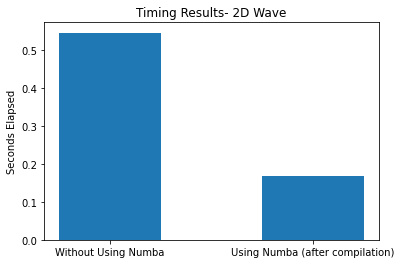

In [18]:
x = 'Without Using Numba', 'Using Numba (after compilation)'
times = time_1, time_3
y = times
plt.bar(x, y, width = 0.5)
plt.ylabel('Seconds Elapsed')
plt.title('Timing Results- 2D Wave')
plt.show()

Text(0.5, 0, 'Z')

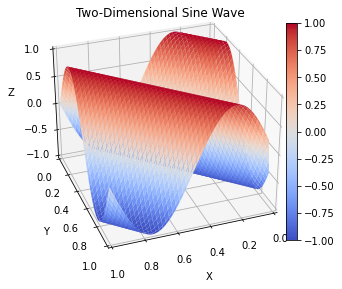

In [19]:
# Animate wave amplitudes
map_array = fast_numerical_sol()
frames = map_array[:, :, 0::20]  # contains every 20th map

fig = plt.figure()  # initial figure

ax = fig.gca(projection = '3d')  # three-dimensional view of projection

surface = (ax.plot_surface(X, Y, frames[:, :, 0], rstride = 2, cstride = 2,
                        cmap = 'coolwarm', vmax = 1, vmin = -1))  # initial surface plot

ax.set_title('Two-Dimensional Sine Wave')  # plot title

fig.colorbar(surface)  # add a colorbar to plot
ax.view_init(elev = 30, azim = 70)  # initial elevation and angle view
ax.dist = 8  # viewing distance

# axis labels and limits
ax.set_xlim3d([0.0, 1.0])
ax.set_xlabel('X')

ax.set_ylim3d([0.0, 1.0])
ax.set_ylabel('Y')

ax.set_zlim3d([-1.0, 1.0])
ax.set_zlabel('Z')